# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [633]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/schypo')
import estimator, simulate, schypo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


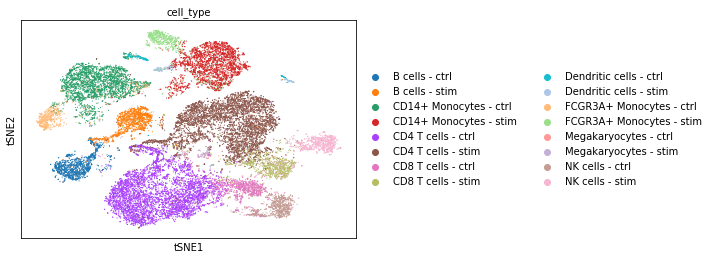

In [13]:
sc.pl.tsne(adata, color='cell_type')

In [14]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [15]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [593]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

In [703]:
tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
tfs = tf_df['GeneSym'].tolist()

In [612]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Plotting functions

In [32]:
def get_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr'])

def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell','stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'ct','stim','ind', 'corr'])

### Read the transcriptome wide IFN result

In [18]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()

schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)

target_genes = adata_ct.var.index.tolist()

schypo.compute_2d_moments(
    adata_ct, 
    target_genes, 
    target_genes)

In [19]:
adata_ct.uns['schypo']['2d_ht'] = {
    'corr_asl':np.zeros((len(target_genes), len(target_genes))),
    'corr_coef':np.zeros((len(target_genes), len(target_genes))),
}

In [20]:
genes_per_batch = 20
for batch in range(int(len(target_genes)/genes_per_batch)+1):
    
    adata_chunk = sc.read(data_path + 'result_2d/mono_ifn/{}.h5ad'.format(batch))
    adata_ct.uns['schypo']['2d_ht']['corr_asl'][(genes_per_batch*batch):(genes_per_batch*(batch+1)), :] = adata_chunk.uns['schypo']['2d_ht']['corr_asl']
    adata_ct.uns['schypo']['2d_ht']['corr_coef'][(genes_per_batch*batch):(genes_per_batch*(batch+1)), :] = adata_chunk.uns['schypo']['2d_ht']['corr_coef']

In [21]:
adata_ct.write(data_path + 'result_2d/mono_ifn/combined.h5ad')

... storing 'schypo_group' as categorical


In [22]:
imp.reload(schypo)

<module 'schypo' from '/data/home/Github/scrna-parameter-estimation/schypo/schypo.py'>

### Get the results

In [23]:
mono_result_df = schypo.get_2d_ht_result(adata_ct).query('corr_coef > -2 & corr_coef < 2')

In [283]:
mono_result_df['tf_corr'] = mono_result_df['gene_1'].isin(tfs) | mono_result_df['gene_2'].isin(tfs)


In [558]:
# mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, isg_indices][isg_indices, :]
# mat[np.absolute(mat) > 2] = np.nan
# mat[np.isnan(mat)] = 0

heatmap_df = pd.DataFrame(
    adata_ct.uns['schypo']['2d_ht']['corr_asl'],
    index=target_genes,
    columns=target_genes).fillna(0.0)
heatmap_df[heatmap_df.abs() > 2] = 0

heatmap_df[:] = -np.log10(heatmap_df.values)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [719]:
sig_df = mono_result_df.query('corr_fdr < 0.1').copy()
sig_df['mag'] = sig_df['corr_coef'].abs()
sig_df['tf_corr'] = sig_df['gene_1'].isin(tfs) | sig_df['gene_2'].isin(tfs)

sig_counts = sig_df.gene_1.tolist() + sig_df.gene_2.tolist()
sig_counts = pd.Series(collections.Counter(sig_counts))

tf_sig = (set(tfs) & set(sig_counts[sig_counts > 10].index)) #- set(['THAP1'])
print(len(tf_sig))

35


In [964]:
sig_genes = sig_counts[sig_counts > 10].index.tolist()
gene_to_id = dict(zip(sig_genes, range(len(sig_genes))))

In [965]:
len(sig_genes)

2069

In [966]:
sig_df.query('gene_1 in @sig_genes & gene_2 in @sig_genes').shape

(49022, 7)

In [967]:
import igraph as ig
import leidenalg as la

In [980]:
g = ig.Graph()
g.add_vertices(len(sig_genes))
for idx, row in sig_df.iterrows():
    if row['gene_1'] in sig_genes and row['gene_2'] in sig_genes:
        g.add_edge(gene_to_id[row['gene_1']], gene_to_id[row['gene_2']], weight=np.abs(row['corr_coef']))

In [1000]:
partition = la.ModularityVertexPartition(g)
optimiser = la.Optimiser()
diff = optimiser.optimise_partition(partition)

In [1001]:
np.unique(partition.membership).shape

(9,)

In [1002]:
np.bincount(partition.membership)#.sum()

array([477, 474, 199, 185, 184, 177, 160, 145,  68])

In [1021]:
d = gseapy.enrichr(
    gene_list=np.array(sig_genes)[np.array(partition.membership)==8].tolist(), 
    description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea')


2020-06-08 20:16:34,270 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


In [1022]:
d.res2d.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Glyoxylate and dicarboxylate metabolism,2/30,0.004659,1.0,0,0,19.607843,105.271916,GRHPR;PGP
1,KEGG_2019_Human,"Glycine, serine and threonine metabolism",2/40,0.008174,1.0,0,0,14.705882,70.687810,GRHPR;SDS
2,KEGG_2019_Human,Spliceosome,3/134,0.010734,1.0,0,0,6.584723,29.857267,HSPA8;DDX23;PRPF31
3,KEGG_2019_Human,Influenza A,3/171,0.020517,1.0,0,0,5.159959,20.054109,HSPA8;TNFSF10;IKBKE
4,KEGG_2019_Human,Riboflavin metabolism,1/8,0.026883,1.0,0,0,36.764706,132.950800,RFK
5,KEGG_2019_Human,Antigen processing and presentation,2/77,0.028295,1.0,0,0,7.639419,27.234964,HSPA8;LGMN
6,KEGG_2019_Human,mRNA surveillance pathway,2/91,0.038421,1.0,0,0,6.464124,21.067526,SMG1;PPP2R5E
7,KEGG_2019_Human,Glucagon signaling pathway,2/103,0.048030,1.0,0,0,5.711022,17.338263,PHKB;SIK2
8,KEGG_2019_Human,Measles,2/138,0.080200,1.0,0,0,4.262575,10.755460,HSPA8;IKBKE
9,KEGG_2019_Human,Biosynthesis of unsaturated fatty acids,1/27,0.087909,1.0,0,0,10.893246,26.486361,ELOVL5


In [773]:
np.unique(partition.membership).shape

(12,)

In [774]:
np.bincount(partition.membership)

array([608, 471, 420, 294, 276, 239, 206, 193, 171, 143, 131, 123])

In [747]:
partition

In [736]:
g = ig.Graph()

In [737]:
g

In [720]:
tf_sig

{'ATF1',
 'ATF2',
 'BATF',
 'BDP1',
 'CCNT2',
 'CEBPB',
 'CEBPZ',
 'CREBBP',
 'GABPA',
 'HMGN3',
 'IKZF1',
 'MAFK',
 'MEF2C',
 'MYC',
 'NFYB',
 'PHF8',
 'POLR2A',
 'POU2F2',
 'RCOR1',
 'RNF2',
 'SIN3A',
 'SIRT6',
 'SMARCC2',
 'SP1',
 'SUPT20H',
 'SUZ12',
 'THAP1',
 'USF2',
 'XRCC4',
 'ZBTB7A',
 'ZC3H11A',
 'ZMIZ1',
 'ZNF217',
 'ZNF263',
 'ZNF274'}

In [683]:
def get_gene_partners(gene):
    
    genes = []
    genes += sig_df.query('gene_1 == "{}"'.format(gene)).gene_2.tolist()
    genes += sig_df.query('gene_2 == "{}"'.format(gene)).gene_1.tolist()
    
    return list(set(genes))

In [684]:
import functools

In [692]:
tf_partners = {tf:get_gene_partners(tf) for tf in tf_sig}

In [710]:
irfs = ['IRF' + str(i) for i in range(3)]
stats = [gene for gene in target_genes if 'STAT' in gene]
stats = [gene for gene in target_genes if 'STAT' in gene]

In [726]:
'IRF5' in target_genes

True

In [709]:
sig_df.query('gene_1 in @irfs | gene_2 in @irfs & corr_coef > 0').sort_values('corr_pval').head(100)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,tf_corr,mag
4051650,IRF1,ZNF81,-0.801103,0.000001,0.000377,True,0.801103
4051217,IRF1,CLK4,0.587885,0.000091,0.014229,True,0.587885
4053487,IRF1,C19orf59,0.645830,0.000492,0.065781,True,0.645830


In [728]:
sig_df.query('gene_1 == "STAT3" | gene_2 == "STAT3" & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,tf_corr,mag


In [ ]:
go_dict = {}
kegg_dict = {}

for tf in tf_sig:
    kegg_df = gseapy.enrichr(gene_list=tf_partners[tf], description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea').res2d
    go_df = gseapy.enrichr(gene_list=tf_partners[tf], description='ontology', gene_sets='GO_Biological_Process_2018', outdir='gsea').res2d
    
    go_df = go_df[go_df['Adjusted P-value'] < 0.1].copy()
    kegg_df = kegg_df[kegg_df['Adjusted P-value'] < 0.1].copy()
    
    go_dict[tf] = go_df.copy()
    kegg_dict[tf] = kegg_df.copy()
        
    print(tf, go_df.shape, kegg_df.shape)


2020-06-08 16:43:57,152 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:43:59,284 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


BATF (0, 10) (0, 10)


2020-06-08 16:44:01,221 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:03,353 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KLF4 (0, 10) (0, 10)


2020-06-08 16:44:05,314 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:07,465 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


MAFK (0, 10) (0, 10)


2020-06-08 16:44:09,342 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:11,317 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF274 (0, 10) (0, 10)


2020-06-08 16:44:13,203 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:15,186 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KDM2B (0, 10) (0, 10)


2020-06-08 16:44:17,046 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:19,006 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


BPTF (0, 10) (0, 10)


2020-06-08 16:44:20,889 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:22,871 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ELF4 (0, 10) (0, 10)


2020-06-08 16:44:24,714 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:26,566 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF143 (0, 10) (0, 10)


2020-06-08 16:44:28,420 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:30,281 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


SP3 (0, 10) (0, 10)


2020-06-08 16:44:32,161 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:34,146 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ATF2 (0, 10) (0, 10)


2020-06-08 16:44:36,226 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:38,518 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF770 (0, 10) (0, 10)


2020-06-08 16:44:40,389 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:42,363 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KMT2A (0, 10) (0, 10)


2020-06-08 16:44:44,300 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:46,432 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


VDR (0, 10) (0, 10)


2020-06-08 16:44:48,307 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:50,283 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ARNTL (0, 10) (0, 10)


2020-06-08 16:44:52,173 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:54,264 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


TOPORS (0, 10) (0, 10)


2020-06-08 16:44:56,127 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:44:57,983 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF467 (0, 10) (0, 10)


2020-06-08 16:44:59,821 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


MTF2 (5, 10) (0, 10)


2020-06-08 16:45:04,349 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:07,040 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZBTB22 (0, 10) (0, 10)


2020-06-08 16:45:08,983 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:11,128 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


GMEB1 (0, 10) (0, 10)


2020-06-08 16:45:12,992 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:14,967 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


MYC (0, 10) (0, 10)


2020-06-08 16:45:19,167 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


HIVEP1 (0, 10) (5, 10)


2020-06-08 16:45:21,038 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:23,017 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


LCORL (0, 10) (0, 10)


2020-06-08 16:45:24,999 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:27,282 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


RREB1 (0, 10) (0, 10)


2020-06-08 16:45:29,204 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:31,317 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


E2F3 (0, 10) (0, 10)


2020-06-08 16:45:33,219 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:35,346 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


POU2F1 (0, 10) (0, 10)


2020-06-08 16:45:37,236 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:39,340 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF75A (0, 10) (0, 10)


2020-06-08 16:45:41,206 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:43,182 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


NFYB (0, 10) (0, 10)


2020-06-08 16:45:45,056 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:47,032 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ATF1 (0, 10) (0, 10)


2020-06-08 16:45:48,965 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:51,100 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF217 (0, 10) (0, 10)


2020-06-08 16:45:53,076 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:55,313 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


MEF2C (0, 10) (0, 10)


2020-06-08 16:45:57,185 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:45:59,144 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


XBP1 (0, 10) (0, 10)


2020-06-08 16:46:00,999 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:02,950 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


E2F4 (0, 10) (0, 10)


2020-06-08 16:46:07,862 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


STAT5B (1, 10) (13, 10)


2020-06-08 16:46:09,765 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:11,878 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


LEF1 (0, 10) (0, 10)


2020-06-08 16:46:13,743 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:15,722 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF224 (0, 10) (0, 10)


2020-06-08 16:46:17,670 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:19,876 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


CXXC1 (0, 10) (0, 10)


2020-06-08 16:46:21,794 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:23,921 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


NFAT5 (1, 10) (0, 10)


2020-06-08 16:46:25,758 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:27,601 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KLF10 (0, 10) (0, 10)


2020-06-08 16:46:29,462 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:31,433 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF22 (0, 10) (0, 10)


2020-06-08 16:46:33,290 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:35,155 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF350 (0, 10) (0, 10)


2020-06-08 16:46:37,064 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:39,188 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


TFDP1 (0, 10) (0, 10)


2020-06-08 16:46:41,040 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:42,994 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


IRF5 (0, 10) (0, 10)


2020-06-08 16:46:47,041 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


NFE2L1 (0, 10) (1, 10)


2020-06-08 16:46:48,946 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:51,044 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF281 (0, 10) (0, 10)


2020-06-08 16:46:52,880 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:54,725 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


OLIG1 (0, 10) (0, 10)


2020-06-08 16:46:56,579 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:46:58,544 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


CUX1 (0, 10) (0, 10)


2020-06-08 16:47:00,396 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:02,250 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


PHF1 (0, 10) (0, 10)


2020-06-08 16:47:04,113 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:06,073 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


RUNX1 (0, 10) (0, 10)


2020-06-08 16:47:08,019 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:10,161 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF32 (0, 10) (0, 10)


2020-06-08 16:47:12,019 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:13,982 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


DNMT1 (0, 10) (0, 10)


2020-06-08 16:47:15,844 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:17,811 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


FOXN3 (0, 10) (0, 10)


2020-06-08 16:47:19,800 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:22,088 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF3 (1, 10) (0, 10)


2020-06-08 16:47:23,946 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:25,915 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


IKZF1 (0, 10) (0, 10)


2020-06-08 16:47:27,899 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:30,192 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF263 (0, 10) (0, 10)


2020-06-08 16:47:32,071 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:34,160 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


TRPS1 (0, 10) (0, 10)


2020-06-08 16:47:36,249 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:38,510 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF430 (0, 10) (0, 10)


2020-06-08 16:47:40,364 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:42,209 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


VEZF1 (0, 10) (0, 10)


2020-06-08 16:47:44,257 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:46,394 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


GABPA (0, 10) (0, 10)


2020-06-08 16:47:48,262 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:50,224 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF581 (0, 10) (0, 10)


2020-06-08 16:47:54,243 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


MAFB (0, 10) (2, 10)


2020-06-08 16:47:56,127 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:47:58,108 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZFX (0, 10) (0, 10)


2020-06-08 16:48:00,000 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


ATF6 (4, 10) (1, 10)


2020-06-08 16:48:04,197 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:06,173 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


POU2F2 (0, 10) (0, 10)


2020-06-08 16:48:10,645 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


MYNN (0, 10) (1, 10)


2020-06-08 16:48:12,499 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:14,475 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ELK3 (0, 10) (0, 10)


2020-06-08 16:48:16,331 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:18,174 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ELF2 (0, 10) (0, 10)
CEBPB (19, 10) (1, 10)


2020-06-08 16:48:24,314 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:26,163 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KLF3 (0, 10) (0, 10)


2020-06-08 16:48:28,020 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:29,995 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


SP1 (0, 10) (0, 10)


2020-06-08 16:48:31,904 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:34,008 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF44 (0, 10) (0, 10)


2020-06-08 16:48:35,868 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:37,828 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


FOXO3 (0, 10) (0, 10)


2020-06-08 16:48:40,125 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:42,743 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF81 (0, 10) (0, 10)


2020-06-08 16:48:44,597 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:46,446 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZBTB7A (0, 10) (0, 10)


2020-06-08 16:48:48,401 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:50,662 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF317 (0, 10) (0, 10)


2020-06-08 16:48:52,508 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:54,354 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


REST (0, 10) (0, 10)


2020-06-08 16:48:56,233 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:48:58,221 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


CEBPZ (0, 10) (0, 10)


2020-06-08 16:49:00,145 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:02,275 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


KLF11 (0, 10) (0, 10)


2020-06-08 16:49:04,136 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:06,103 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


IRF8 (0, 10) (0, 10)


2020-06-08 16:49:07,965 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:09,929 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


PKNOX1 (0, 10) (0, 10)


2020-06-08 16:49:11,908 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:14,198 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF791 (0, 10) (0, 10)


2020-06-08 16:49:16,098 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:18,222 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF524 (0, 10) (0, 10)


2020-06-08 16:49:20,064 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:21,907 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


USF2 (0, 10) (0, 10)


2020-06-08 16:49:23,818 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:25,932 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


TCF7 (0, 10) (0, 10)


2020-06-08 16:49:27,849 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:30,190 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF701 (0, 10) (0, 10)


2020-06-08 16:49:32,091 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:34,185 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZBTB1 (0, 10) (0, 10)


2020-06-08 16:49:36,075 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:38,178 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


LCOR (0, 10) (0, 10)


2020-06-08 16:49:40,038 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:42,007 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


SATB1 (0, 10) (0, 10)


2020-06-08 16:49:43,942 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:46,075 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ETV3 (0, 10) (0, 10)


2020-06-08 16:49:47,994 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:50,118 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


ZNF33A (0, 10) (0, 10)


2020-06-08 16:49:51,980 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:53,937 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


THAP1 (0, 10) (0, 10)


2020-06-08 16:49:55,790 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-06-08 16:49:57,635 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


JUNB (0, 10) (0, 10)


In [691]:
go_dict['BATF']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [689]:
include_tfs = []
for tf in tf_sig:
    
    print(tf, '====================================================')
    if go_dict[tf].shape[0] > 0:
        print(go_dict[tf].to_string())
    if kegg_dict[tf].shape[0] > 0:
        print(kegg_dict[tf].to_string())
    if go_dict[tf].shape[0] > 0 or kegg_dict[tf].shape[0] > 0:
        include_tfs.append(tf)

BATF ====================================================
KLF4 ====================================================
MAFK ====================================================
ZNF274 ====================================================
KDM2B ====================================================
BPTF ====================================================
ELF4 ====================================================
ZNF143 ====================================================
SP3 ====================================================
ATF2 ====================================================
ZNF770 ====================================================
KMT2A ====================================================
VDR ====================================================
ARNTL ====================================================
TOPORS ====================================================
ZNF467 ====================================================
MTF2 ====================================================
   

In [693]:
gene_order = functools.reduce(lambda x,y: x + y, [tf_partners[tf] for tf in include_tfs])

In [729]:
sig_df.head(5)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,tf_corr,mag
10,NOC2L,PANK4,1.290662,0.000000e+00,0.000000e+00,False,1.290662
11,NOC2L,LRRC47,1.310819,7.713720e-05,1.230589e-02,False,1.310819
28,NOC2L,MTHFR,0.401017,6.367856e-14,7.834770e-11,False,0.401017
36,NOC2L,ZBTB17,0.201517,4.424133e-05,7.507443e-03,False,0.201517
39,NOC2L,CDA,0.264003,2.856898e-07,1.143270e-04,False,0.264003


([], <a list of 0 Text xticklabel objects>)

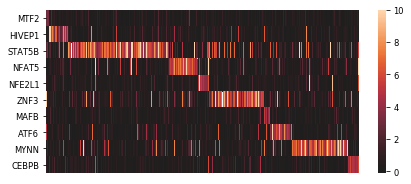

In [696]:
plt.figure(figsize=(7, 3))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

sns.heatmap(heatmap_df.loc[gene_order, include_tfs].T, vmin=-0.1, vmax=10, center=0)
plt.xticks([])

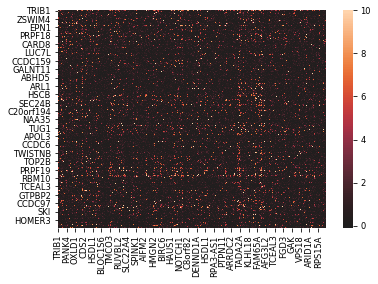

In [697]:
sns.heatmap(heatmap_df.loc[gene_order, gene_order], vmin=-0.1, vmax=10, center=0)


In [567]:
tf_sig_df = sig_df.query('gene_1 in @tf_sig | gene_2 in @tf_sig')
tf_sig_genes = set(tf_sig_df.gene_1.tolist() + tf_sig_df.gene_2.tolist()) - sig_tfs
tf_sig_genes &= set(sig_counts[sig_counts > 5].index)

In [492]:
'TXN' in tf_sig_genes

False

In [493]:
print(len(tf_sig), len(tf_sig_genes))

12 251


In [413]:
tf_heatmap_df = heatmap_df.loc[tf_sig_genes, tf_sig]

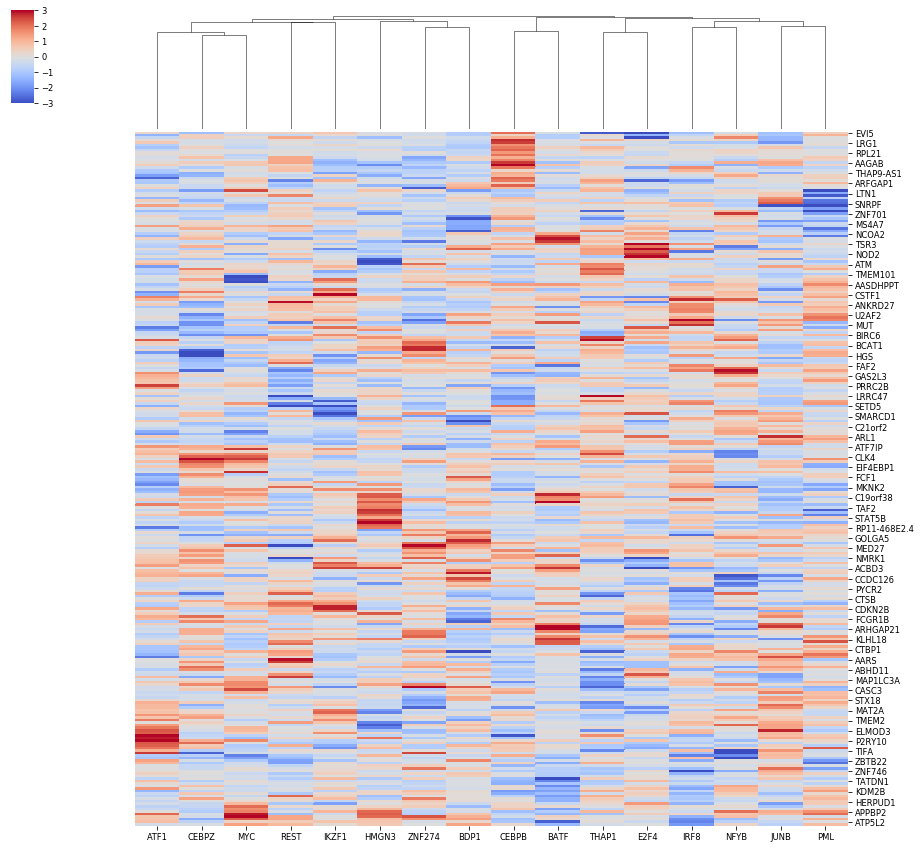

In [414]:
cg = sns.clustermap(tf_heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-3, vmax=3, z_score=1, figsize=(15, 15))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)
# plt.close()
# row_order = cg.dendrogram_row.reordered_ind
# col_order = ['ATF1', 'REST', 'NR3C1', 'BDP1','HMGN3', 'BATF','E2F4', 'CEBPZ', 'SMC3']
# sns.heatmap(tf_heatmap_df.iloc[row_order, :].loc[:, col_order], cmap='coolwarm', vmin=-1, vmax=1)

# plt.close()

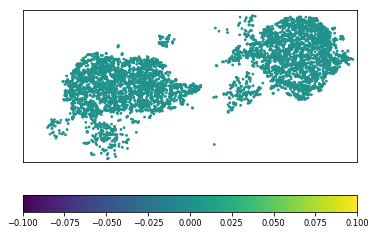

In [1023]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'TYR'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)


In [89]:
for gene in tf_sig:
    plt.figure(figsize=(4.5, 3))
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene)
    plt.close()


### Check SAT1 and TXN correlations

In [279]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata[(norm_adata.obs.cell == ct)]


def variability_scatter(X, c, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [25]:
mono_1d_result = pd.read_csv('cd14_1d_result.csv')

In [239]:
import collections

In [242]:
isg_genes = mono_1d_result.query('distance < 1').gene.tolist()
isg_genes = list(set(isg_genes) & set(target_genes))

tf_genes = list(set(tfs) & set(target_genes))

sig_genes = sig_df.gene_1.tolist() + sig_df.gene_2.tolist()
sig_genes = pd.Series(collections.Counter(sig_genes))

sig_genes = list(set(sig_genes[sig_genes > 5].index.tolist()))

In [243]:
mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, isg_indices][isg_indices, :]
mat[np.absolute(mat) > 2] = np.nan
mat[np.isnan(mat)] = 0

heatmap_df = pd.DataFrame(
    mat,
    index=target_genes,
    columns=target_genes).fillna(0.0)
heatmap_df = heatmap_df.loc[sig_genes, sig_genes]

mat = heatmap_df.values

In [244]:
from sklearn.cluster import AgglomerativeClustering

In [250]:
clustering = AgglomerativeClustering(n_clusters=400).fit(mat)

In [251]:
clustering_result = pd.Series(clustering.labels_, index=sig_genes)

In [252]:
'ISG15' in sig_genes

True

In [192]:
clustering.labels_

array([17,  7, 21, ...,  5,  7,  7])

In [ ]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-1, vmax=1, z_score=None)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind

plt.close()

### Create some heatmaps

In [103]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [51]:
gene_order = np.array(target_genes)[row_order]

In [52]:
heatmap_df_clustered = heatmap_df.loc[gene_order, gene_order].copy()

In [58]:
np.where(gene_order == 'SAT1')[0][0]

348

In [76]:
'SEC61A1' in target_genes

True

In [80]:
def get_module(gene_order, start, end):
    
    start_idx = np.where(gene_order == start)[0][0]
    end_idx = np.where(gene_order == end)[0][0]
    
    return gene_order[start_idx:end_idx].tolist()

In [128]:
modules = []
modules.append(get_module(gene_order, 'SMARCD1', 'ZNF44'))
modules.append(get_module(gene_order, 'FOXO3', 'ITFG1'))
modules.append(get_module(gene_order, 'MAT2B', 'CD96'))
modules.append(get_module(gene_order, 'SEC61A1', 'HSPA6'))
modules.append(get_module(gene_order, 'VAV3', 'SF3B5'))
modules.append(get_module(gene_order, 'MSL3', 'CWC27'))
modules.append(get_module(gene_order, 'SHKBP1', 'ATXN3'))
modules.append(get_module(gene_order, 'NCSTN', 'CHCHD2'))

import functools
combined_module = functools.reduce(lambda x, y: x+y, modules)

In [171]:
np.where(gene_order == 'ISG15')[0][0]

138

In [179]:
idx= np.where(gene_order == 'TXN')[0][0]
print(idx)

3564


In [182]:
for gene in target_genes:
    if 'HLA-D' in gene:
        print(gene)

HLA-DRA
HLA-DRB5
HLA-DRB1
HLA-DQA1
HLA-DQB1
HLA-DMA
HLA-DPA1
HLA-DPB1


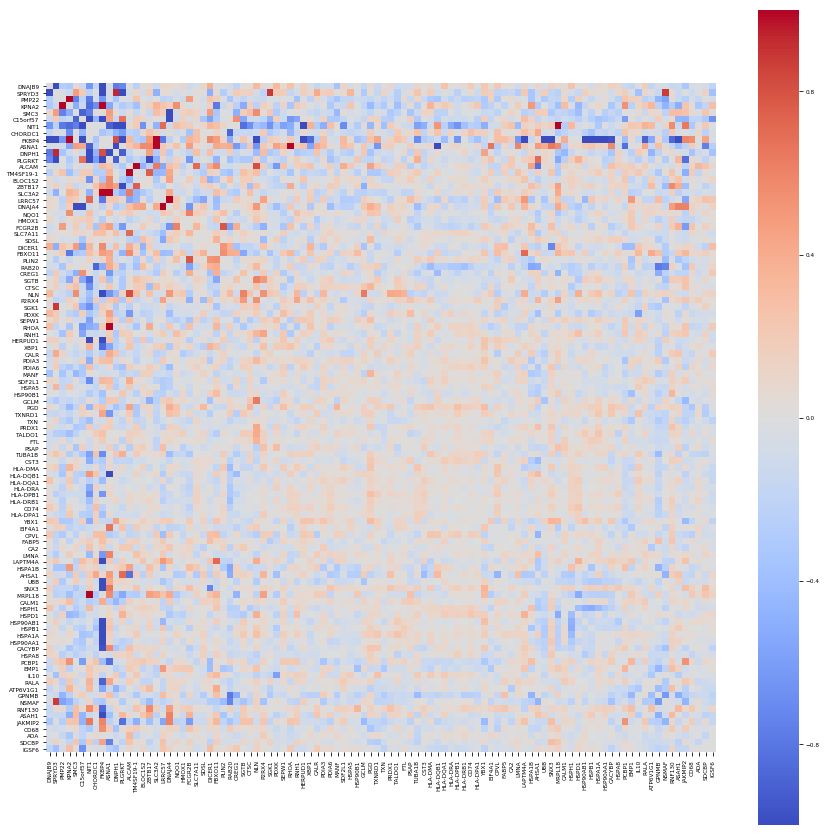

In [180]:
plt.figure(figsize=(15, 15))


ax = sns.heatmap(heatmap_df_clustered.iloc[idx-50:idx+50, idx-50:idx+50],center=0, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_aspect("equal")

In [129]:
import gseapy

Creating directory /home/ssm-user/.config/bioservices 


In [169]:
gseapy.enrichr(gene_list=modules[2], description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea')
# enrichr_result = pd.read_csv('gsea/KEGG_2019_Human.pathway.enrichr.reports.txt', sep='\t')

In [ ]:
enrichr_result

In [126]:
for idx, module in enumerate(modules):
    print('module', idx)
    
    print('tfs', set(module)&set(tfs))
    print('isg', set(module)&set(isg_genes))

module 0
tfs set()
isg set()
module 1
tfs {'BDP1', 'IRF8', 'IRF2'}
isg {'NADK', 'CREBRF', 'PARP10'}
module 2
tfs {'NR3C1'}
isg {'EXOSC9'}
module 3
tfs set()
isg {'DNAJB4'}
module 4
tfs {'REST'}
isg {'PPP2R2A'}


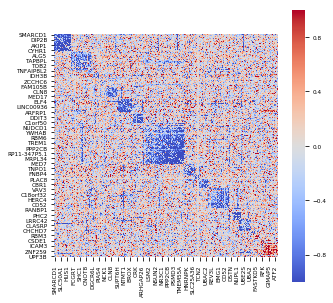

In [127]:
plt.figure(figsize=(5, 5))
ax = sns.heatmap(heatmap_df_clustered.loc[combined_module, combined_module],center=0, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_aspect("equal")

In [504]:
row_order[:5]

[464, 479, 577, 264, 244]

In [505]:
col_order[:5]

[303, 358, 224, 539, 153]

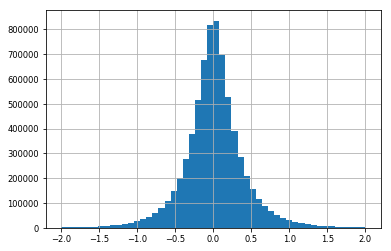

In [484]:
mono_result_df['corr_coef'].hist(bins=50)

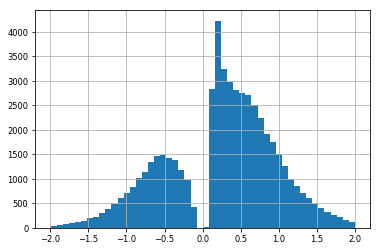

In [483]:
sig_df['corr_coef'].hist(bins=50)

In [438]:
sig_genes = sig_df.groupby('gene_1').size() + sig_df.groupby('gene_2').size()
sig_genes = sig_genes[sig_genes > 100].index.tolist()
# sig_genes = list(set(tfs) & set(target_genes))
# sig_genes = ['IRF1', 'IRF2', 'IRF7', 'IRF8']
sig_gene_indices = [target_genes.index(gene) for gene in sig_genes]

In [440]:
plot_genes = []
num_per_sig = 20
for gene in sig_genes:
    
    d1 = sig_df.query('gene_1 == "{}"'.format(gene))
    d2 = sig_df.query('gene_2 == "{}"'.format(gene))
    
    sorted_coef = np.sort(np.concatenate([d1['corr_coef'].values, d2['corr_coef'].values]))
    up_cutoff, low_cutoff = sorted_coef[-num_per_sig], sorted_coef[num_per_sig]
    up_cutoff, low_cutoff = 0, 0
    
    plot_genes += d1.query('corr_coef >= {} | corr_coef <= {}'.format(up_cutoff, low_cutoff)).gene_2.tolist()
    plot_genes += d2.query('corr_coef >= {} | corr_coef <= {}'.format(up_cutoff, low_cutoff)).gene_1.tolist()

plot_genes = list(set(plot_genes))
plot_gene_indices = [target_genes.index(gene) for gene in plot_genes]

In [441]:
len(plot_genes)

3037

In [476]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mat = adata_ct.uns['schypo']['2d_ht']['corr_coef'][:, sig_gene_indices][plot_gene_indices, :]
mat[np.absolute(mat) > 2] = np.nan

# mat = StandardScaler().fit_transform(mat)

heatmap_df = pd.DataFrame(
    mat,
    index=plot_genes,
    columns=sig_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)


mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, sig_gene_indices][plot_gene_indices, :]
mat[np.absolute(mat) > 2] = np.nan

heatmap_df = pd.DataFrame(
    mat,
    index=target_genes,
    columns=target_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)

In [470]:
clustering.labels_

array([17,  7, 21, ...,  5,  7,  7])

In [462]:
heatmap_df.shape

(3764, 3764)

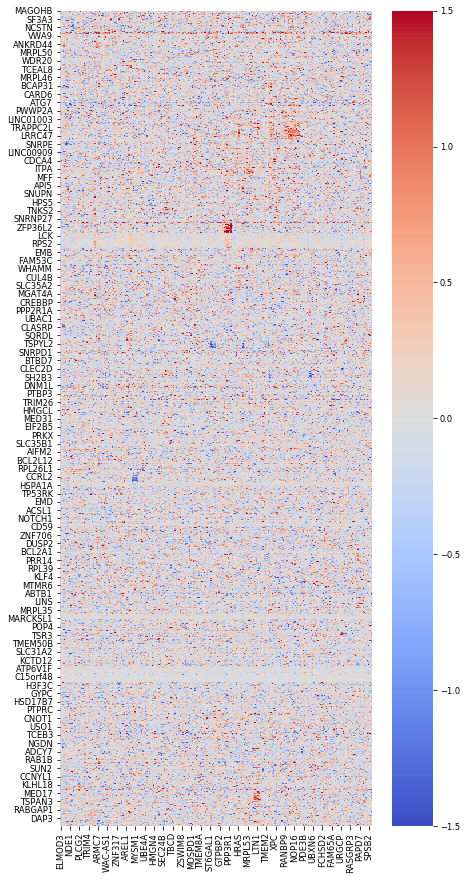

In [460]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-1.5, vmax=1.5, z_score=1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
plt.close()

plt.figure(figsize=(7, 15))
sns.heatmap(heatmap_df.iloc[row_order, col_order],center=0, vmin=-1.5, vmax=1.5, cmap='coolwarm')


### Differences between ISGs

In [361]:
mat = adata_ct.uns['schypo']['2d_ht']['corr_coef'][:, isg_indices][isg_indices, :]
mat[np.absolute(mat) > 2] = np.nan

heatmap_df = pd.DataFrame(
    mat,
    index=isg_genes,
    columns=isg_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


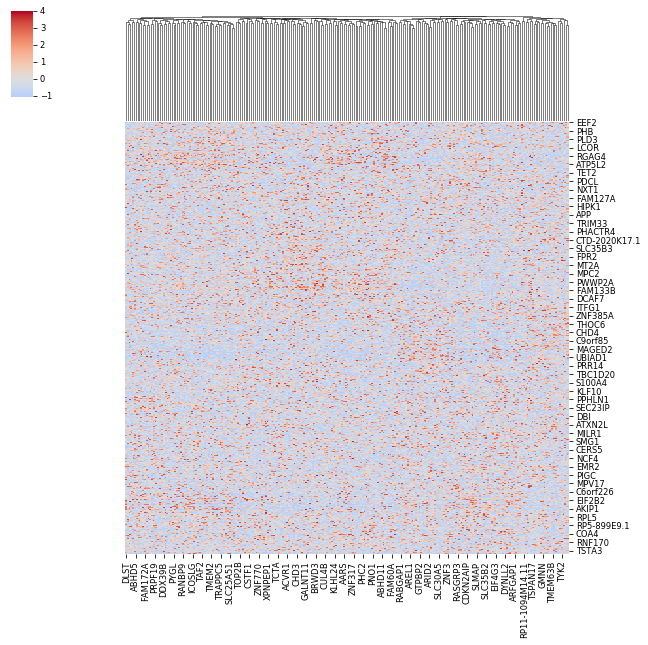

In [398]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, z_score=1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)
row_order = cg.dendrogram_row.reordered_ind


In [342]:
np.array(isg_genes)[row_order]

array(['HIST1H4H', 'ICAM2', 'DMTF1', 'APOL1', 'ZC3HAV1', 'CFLAR', 'TDRD7',
       'BTG3', 'C5orf56', 'CREBRF', 'EXOSC9', 'TRIM56', 'CCRL2', 'CD53',
       'TRIP4', 'PPP2R2A', 'CITED2', 'TRIM14', 'HSP90AB1', 'HSPD1', 'LYN',
       'DNAJB4', 'CNPPD1', 'CYB5R4', 'GCLM', 'PSMF1', 'BAZ2A', 'MYL12A',
       'CGGBP1', 'C3orf38', 'PSMB8', 'FAM111A', 'TRIM22', 'GSTK1',
       'STX17', 'DTX3L', 'TPD52L2', 'NADK', 'LNPEP', 'CNP', 'NBN',
       'PLSCR1', 'TAP1', 'RP11-701P16.5', 'MTHFD2', 'DDX58', 'WARS',
       'WTAP', 'IRF7', 'PARP10', 'TRIM69', 'PARP9', 'SAMD9', 'SP140L',
       'EIF2AK2', 'PARP14', 'B2M', 'IFIH1', 'EPSTI1', 'SHISA5', 'SP110',
       'ISG20', 'ISG15', 'TNFSF13B', 'XAF1', 'IFI6', 'IFITM3', 'OAS2',
       'NMI', 'TNFSF10', 'IFIT3', 'MX1', 'OAS1', 'PML', 'OASL', 'DDX60L',
       'APOL6', 'PSMB9', 'IRF1', 'DRAP1', 'HIVEP1'], dtype='<U13')

In [335]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)

def variability_scatter(X, c, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [355]:
sig_df.query('gene_1 in @isg_genes & gene_2 in @isg_genes').sort_values('corr_coef')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,mag
7810281,IFITM3,MX1,-1.400877,2.597703e-18,3.750631e-15,1.400877
2328226,SP110,IFITM3,-1.143022,2.037659e-04,2.941245e-02,1.143022
2328652,SP110,OAS1,-1.092747,3.039659e-04,4.231554e-02,1.092747
7594582,IFIT3,TNFSF13B,-1.021164,1.697193e-05,3.279905e-03,1.021164
5781,ISG15,IFIT3,-0.992155,1.543511e-05,3.027080e-03,0.992155
244641,IFI6,MX1,-0.865531,3.241797e-04,4.485982e-02,0.865531
2328986,SP110,ISG20,-0.836389,3.169267e-04,4.394534e-02,0.836389
7809036,IFITM3,OAS1,-0.793251,8.919808e-05,1.401779e-02,0.793251
9412562,OAS1,EPSTI1,-0.626200,2.261392e-04,3.231196e-02,0.626200
243396,IFI6,OAS1,-0.609445,2.067475e-05,3.877078e-03,0.609445


In [359]:
mono_result_df.query('gene_1 == "IFITM3" & gene_2 == "ISG20"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
7809370,IFITM3,ISG20,0.057351,0.840464,1.0


Text(0.5, 1.0, 'ISG20')

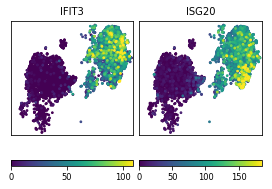

In [356]:
gene_1, gene_2 = 'IFIT3', 'ISG20'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
# plt.savefig(fig_path + 'TXN_IFI6_variability.png', bbox_inches='tight')

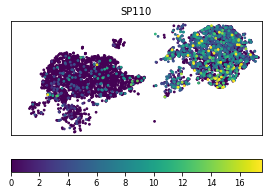

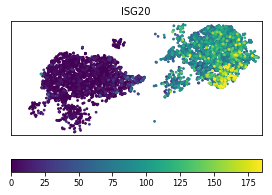

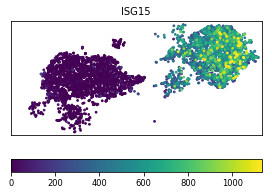

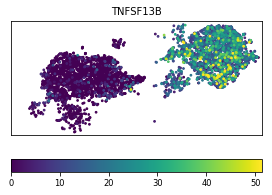

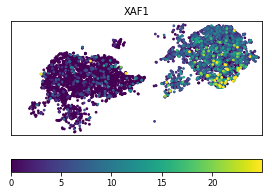

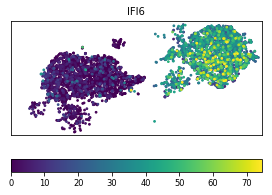

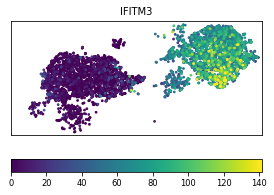

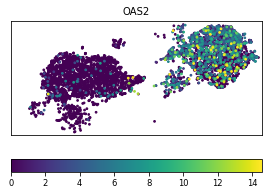

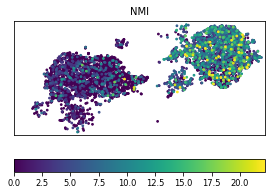

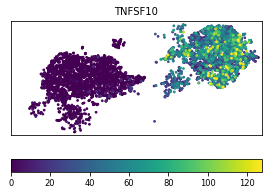

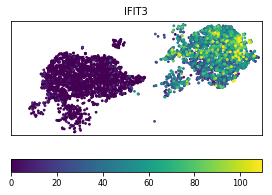

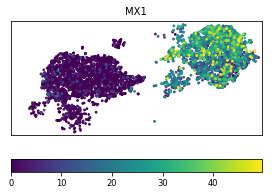

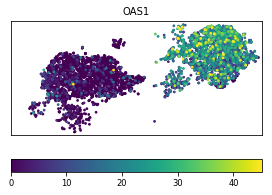

In [347]:
for gene in ['SP110',
       'ISG20', 'ISG15', 'TNFSF13B', 'XAF1', 'IFI6', 'IFITM3', 'OAS2',
       'NMI', 'TNFSF10', 'IFIT3', 'MX1', 'OAS1']:
    plt.figure(figsize=(4.5, 3))
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene)


Text(0.5, 1.0, 'ISG20')

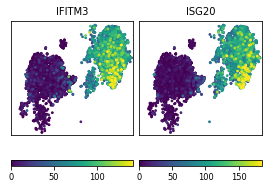

In [345]:
gene_1, gene_2 = 'IFITM3', 'ISG20'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
# plt.savefig(fig_path + 'TXN_IFI6_variability.png', bbox_inches='tight')

In [246]:
heatmap_df.head(5)

,AAGAB,AARS,ABHD11,ABHD17A,ABHD5,ACADS,ACTL6A,ACVR1,ACYP2,ADAP1,...,ZNF263,ZNF3,ZNF317,ZNF430,ZNF770,ZNF791,ZNF81,ZNF92,ZSWIM4,ZSWIM8
FAM174A,-0.044072,-0.346369,-1.000000,0.043907,-0.269937,0.060657,0.471843,0.055803,-0.133425,0.087931,...,-0.087867,0.069594,0.088366,0.631998,0.137247,0.230252,0.045345,-0.300789,0.484308,0.110833
CWC27,-0.002780,-0.072587,0.845431,0.081193,0.576592,0.012960,-0.071374,0.196573,0.182597,-0.348697,...,0.395056,-0.104145,0.097756,-0.527660,0.167849,0.381234,0.071802,0.001576,1.000000,-0.220632
PRKD3,-0.281502,-0.308582,0.068650,-0.016555,0.146570,-0.192667,-0.162248,0.661990,-0.945029,0.144607,...,-0.058862,0.095835,0.002605,-0.088983,-0.366275,0.398149,-0.458723,0.473670,0.075595,0.176745
MRPL9,0.526905,1.000000,0.311913,0.258972,0.579707,-0.015594,-0.376557,0.075647,-0.038041,0.149399,...,-0.018006,-0.642985,-0.710982,0.637548,-0.189146,-0.687825,0.077221,0.252771,-0.033184,0.981564
AARS,0.080371,0.000000,0.059147,0.038809,0.447601,-0.873515,0.424409,0.120936,-0.008438,-0.115163,...,-0.567575,0.342381,0.655328,0.390488,0.885263,0.718945,0.029908,1.000000,-0.669572,0.080314


In [ ]:
gene_counts = pd.DataFrame()
gene_counts['gene'] = 

In [117]:
sig_genes = list(set(mono_result_df.query('corr_fdr < 0.1').gene_1.tolist() + mono_result_df.query('corr_fdr < 0.1').gene_2.tolist()))

In [118]:
len(sig_genes)

3301

In [91]:
mono_result_df.query('corr_fdr < 0.1').shape

(54625, 5)

In [114]:
mono_result_df.query('corr_fdr < 0.1').query('gene_2 == "MYC"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
1033120,HSD17B7,MYC,-0.564956,4.442792e-04,5.990803e-02
1902604,TMEM131,MYC,0.639881,3.071213e-07,1.213334e-04
2858660,GOLGB1,MYC,0.368319,2.668708e-05,4.832537e-03
3046860,MFN1,MYC,-0.982015,4.421472e-04,5.964327e-02
3618988,GALNT7,MYC,0.287553,4.525213e-10,3.811538e-07
4217464,THG1L,MYC,0.552196,1.460307e-05,2.886446e-03
5741884,MRPS33,MYC,0.344049,8.474289e-07,2.799404e-04
5817164,LINC01003,MYC,0.435812,1.601012e-07,7.022366e-05


In [115]:
mono_result_df.query('corr_fdr < 0.1').query('gene_1 == "MYC"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
6716978,MYC,AP3M1,0.746149,4.333699e-05,0.007376
6717141,MYC,CPSF7,0.861352,1.268522e-04,0.019218
6717610,MYC,AP4S1,0.299398,1.517115e-08,0.000009
6717870,MYC,NDE1,-1.245918,3.050211e-08,0.000017
6718078,MYC,TADA2A,0.099077,3.833127e-06,0.000954
6718089,MYC,CASC3,0.747606,0.000000e+00,0.000000
6718144,MYC,APPBP2,0.559867,1.556542e-04,0.023099


In [88]:
a.query('corr_fdr < 0.1').shape

(54623, 5)

In [87]:
mono_result_df.query('corr_fdr < 0.1').shape

(109162, 5)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


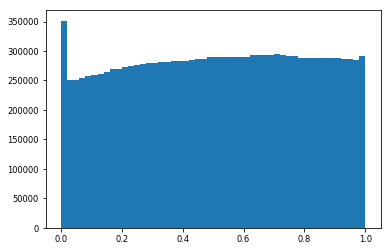

In [517]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=50);

****

### Change in correlation in response to IFN-B in all PBMCs

In [18]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata.copy()#adata[adata.obs.cell == 'B cells'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.7)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (24495, 1861)
TF list length 29


In [43]:
%%time
# scmemo.ht_2d_moments(
#     adata_ct, 
#     formula_like='1 + stim', 
#     cov_column='stim', 
#     num_cpus=6, 
#     num_boot=10000)

# adata_ct.write(data_path + 'result_2d/stim_all_pbmc.h5ad')

# adata_ct = sc.read(data_path + 'result_2d/stim_all_pbmc.h5ad')
# target_genes = adata_ct.var.index.tolist()
# available_tfs = adata_ct.uns['scmemo']['2d_moments']['gene_1']

CPU times: user 122 ms, sys: 101 ms, total: 223 ms
Wall time: 222 ms


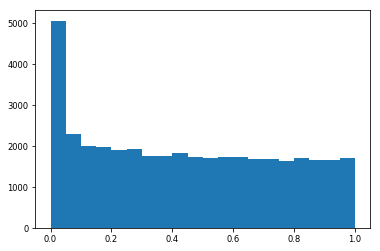

In [39]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [40]:
mat.shape

(1861, 29)

In [41]:
len(valid_tfs)

22

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

result_df = scmemo.get_2d_ht_result(adata_ct).dropna()

valid_counts = result_df.groupby('gene_1').size()
valid_tfs = valid_counts[valid_counts > 1300].index.tolist()

result_df = result_df.query('gene_1 in @valid_tfs')

mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
mat = np.clip(mat, a_min=-0.6, a_max=.6)

heatmap_df = pd.DataFrame(mat, index=target_genes, columns=available_tfs)[valid_tfs].fillna(0.0)

1240


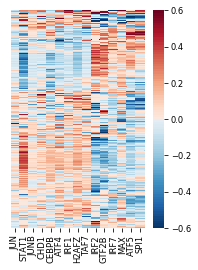

In [45]:
# Draw the heatmap
cg = sns.clustermap(
    heatmap_df[['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']], 
    col_cluster=False
    );
cg.ax_row_dendrogram.set_visible(False)
col_order = ['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']
row_order = cg.dendrogram_row.reordered_ind
plt.close()

select_rows = row_order[:int(len(row_order)/1.5)]
print(len(select_rows))
plt.figure(figsize=(3, 4))
sns.heatmap(heatmap_df[col_order].iloc[select_rows, :], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
# plt.savefig(fig_path + 'tf_heatmap.pdf', bbox_inches='tight')

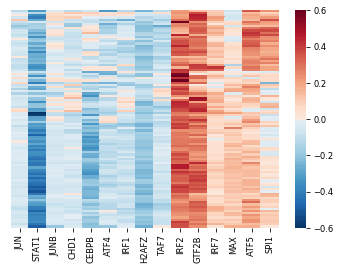

In [75]:
new_heatmap_df = heatmap_df[col_order].iloc[select_rows, :]
sns.heatmap(new_heatmap_df.iloc[200:300], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
genes_1 = new_heatmap_df.iloc[200:300].index.tolist()

In [76]:
print(genes_1)

['DYNLT1', 'GBP5', 'GBP1', 'LAP3', 'MYO1G', 'MBOAT7', 'DDAH2', 'DNAJA1', 'IFI35', 'NAGK', 'WARS', 'SCARB2', 'SNX10', 'OAS1', 'MS4A6A', 'SLC31A2', 'IL4I1', 'PLEK', 'CCRL2', 'C3AR1', 'BST2', 'MGAT1', 'CREG1', 'HPSE', 'CCL2', 'CDKN1A', 'SFT2D1', 'LYN', 'RIT1', 'SHKBP1', 'TNFRSF1A', 'GCLM', 'IRF7', 'TCIRG1', 'ATP6V0D1', 'RNF130', 'AGTRAP', 'GPSM3', 'CYB5R4', 'ATP6V1C1', 'ENY2', 'LACTB', 'GRINA', 'CD48', 'PPP1R15A', 'PLSCR1', 'NAMPT', 'HSBP1', 'GRB2', 'VRK2', 'RAB10', 'PTPRE', 'CCR1', 'NINJ1', 'FNDC3B', 'ATP6V0B', 'CTSZ', 'FTH1', 'PLA2G7', 'CLEC4E', 'S100A10', 'LGALS1', 'FTL', 'ATP6V1F', 'CTSB', 'CFP', 'S100A6', 'GSTO1', 'S100A4', 'C15orf48', 'GRN', 'S100A11', 'LILRB4', 'ANXA2', 'ANXA5', 'CD63', 'KYNU', 'PSAP', 'SOD2', 'SPI1', 'TYROBP', 'CD68', 'FCER1G', 'TYMP', 'BRI3', 'CTSL', 'CSTB', 'LYZ', 'FCGRT', 'SDCBP', 'CTSS', 'CLIC1', 'CFD', 'EMP3', 'DUSP6', 'IGSF6', 'CST3', 'FCN1', 'NPC2', 'GABARAP']


In [ ]:
for gene in genes_1:
    print('---')
    print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format(gene)).sort_values('corr_coef'))

In [57]:
print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef'))

      gene_1 gene_2  corr_coef     corr_pval  corr_fdr
40864  H2AFZ  IL4I1 -0.239784   2.750818e-07  0.000070
20393  STAT1  IL4I1 -0.210088   2.058936e-05  0.001351
18532  IRF1   IL4I1 -0.101022   1.825373e-03  0.056469
25976  JUN    IL4I1 -0.073578   1.556673e-05  0.001055
11088  IRF7   IL4I1  0.168624   3.426383e-03  0.085032
29698  SPI1   IL4I1  0.243244   2.258179e-07  0.000067
22254  GTF2B  IL4I1  0.300408   4.152454e-03  0.096417
35281  ATF5   IL4I1  0.368023   3.340699e-04  0.014433
37142  IRF2   IL4I1  0.445158   4.343105e-03  0.098846


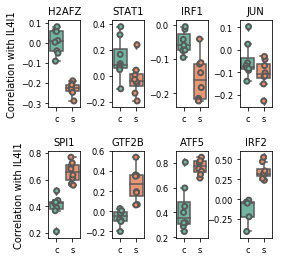

In [58]:
tf_list = df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef').gene_1.tolist()
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=1, hspace=0.5)

idx = 0
for tf in tf_list:
    
    if tf == 'IRF7':
        continue
        
    plt.subplot(2, 4, idx+1)
    gene_1 = tf
    gene_2 = 'IL4I1'
    
    sns.boxplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                palette='Set2')
    sns.stripplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                dodge=True, linewidth=2, palette='Set2')
    plt.title(gene_1)
    
    plt.ylabel(''); plt.xlabel('')

    if idx == 0 or idx == 4:
        plt.ylabel('Correlation with {}'.format(gene_2))
    plt.xticks([0, 1], ['c', 's'])
    
    idx += 1
# plt.savefig(fig_path + 'IL4I1_diff_tfs.pdf', bbox_inches='tight')

### CD4 Analysis

In [387]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.8)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (5341, 1877)
TF list length 31


In [388]:
scmemo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=1000)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 159 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 479 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 927 tasks      | elapsed:   20.4s
[Parallel(n_jobs=6)]: Done 1503 tasks      | elapsed:   31.8s
[Parallel(n_jobs=6)]: Done 2207 tasks      | elapsed:   44.1s
[Parallel(n_jobs=6)]: Done 3039 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 3999 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 5087 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 6303 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 7647 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 9119 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 10719 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 12447 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 14303 tasks      | elapsed:  4.0

In [390]:
# adata_ct.write(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')
# adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')

### CD4/CD14 cells comparison of differential correlation

In [23]:
def get_heatmap_df(adata_ct):
    
    mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
    mat[mat == 0] = np.nan
    mat[mat < -1] = np.nan
    mat[mat > 1] = np.nan

    # mat = np.clip(mat, a_min=-0.6, a_max=0.6)


    means = np.nanmean(mat, axis=0)
    scales = np.nanstd(mat, axis=0)
    mat = (mat - means)/scales
    mat = np.clip(mat, a_min=-1.5, a_max=1.5)
    mat[~np.isfinite(mat)] = 0
    heatmap_df = pd.DataFrame(
        mat, 
        index=adata_ct.uns['scmemo']['2d_moments']['gene_2'], 
        columns=adata_ct.uns['scmemo']['2d_moments']['gene_1']
    ).dropna(0, 'any').fillna(0.0)

    return heatmap_df

In [24]:
adata_Th = adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')
# adata_cM = adata_ct = sc.read(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')

In [25]:
target_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_2']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_2']))
tf_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_1']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_1']))


In [26]:
heatmap_df_Th = get_heatmap_df(adata_Th)[tf_overlap]#.loc[target_overlap]
heatmap_df_Th.columns = heatmap_df_Th.columns + '_Th'

heatmap_df_cM = get_heatmap_df(adata_cM)[tf_overlap]#.loc[target_overlap]
heatmap_df_cM.columns = heatmap_df_cM.columns + '_cM'

heatmap_df_all = pd.concat([heatmap_df_Th, heatmap_df_cM], axis=1)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [27]:
heatmap_df_all.shape

(2366, 38)

In [28]:
result_df_Th = scmemo.get_2d_ht_result(adata_Th)#.dropna()
result_df_cM = scmemo.get_2d_ht_result(adata_cM)#.dropna()

result_df = result_df_Th#pd.concat([result_df_Th, result_df_cM])

sig_df = result_df.sort_values('corr_coef').query('corr_fdr < 0.1')
sig_tf = sig_df.gene_1.drop_duplicates().tolist()
sig_tf = list(set(sig_tf) & set(tf_overlap))
sig_target = list(set(sig_df.gene_2.drop_duplicates().tolist()) & set(target_overlap))

sig_target = [tf for tf in sig_target if 'RP' != tf[:2]]

In [29]:
sig_df.shape

(216, 5)

In [30]:
len(sig_tf)

18

In [31]:
heatmap_df_all.shape

(2366, 38)

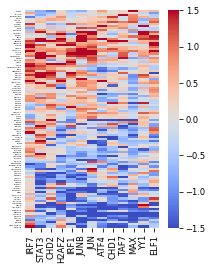

In [196]:
cg = sns.clustermap(
    heatmap_df_Th.loc[sig_target],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
#     metric='cosine'
    );
cg.ax_row_dendrogram.set_visible(False)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
selected_rows = list(range(35, 65)) + list(range(100, 132))
# plt.close()
# cg = sns.clustermap(
#     heatmap_df_Th.loc[sig_target].iloc[selected_rows, col_order],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
#     cmap='coolwarm',
#     row_cluster=False,
#     col_cluster=False,
# #     metric='cosine'
#     );
plt.close()


plt.figure(figsize=(3, 4))
to_drop = ['CBX3_Th','NELFE_Th', 'NR3C1_Th', 'NCOR1_Th', 'GTF2B_Th', 'CEBPB_Th']
temp = heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order]
temp = temp[[col for col in temp.columns if col not in to_drop]]
temp.columns = temp.columns.map(lambda x: x.split('_')[0])
sns.heatmap(temp, cmap='coolwarm')
plt.yticks(np.arange(temp.shape[0])+0.5, temp.index, fontsize=2.4);
plt.tick_params(axis='y', length = 0)
plt.savefig('temp.pdf')
plt.savefig(fig_path + 'cd4_tf_stim_corrs.pdf', bbox_inches='tight')


In [152]:
for gene in heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order].index[10:50]:
    print(result_df.query('gene_2 == "{}"'.format(gene)).query('corr_fdr < 0.1'))

      gene_1  gene_2  corr_coef     corr_pval  corr_fdr
13270  NR3C1  ARID5A -0.311404   4.550345e-05  0.016284
23038  GATA3  ARID5A  0.275710   3.226685e-05  0.013375
29550  JUNB   ARID5A  0.309293   9.278842e-07  0.001673
39318  YY1    ARID5A  0.435190   7.792442e-05  0.023411
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
48721  JUN    TPM4   0.266953   0.000006   0.005495
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
30215  JUNB   IRF7   0.182206   0.00001    0.007185
      gene_1   gene_2  corr_coef  corr_pval  corr_fdr
16641  ATF4   ARL6IP5  0.513776   0.000109   0.030103
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
29809  JUNB   UBE2B  0.254604   0.000063   0.019588
      gene_1  gene_2  corr_coef  corr_pval  corr_fdr
35129  ELF1   UBE2L6  0.398258   0.000016   0.009097
     gene_1 gene_2  corr_coef  corr_pval  corr_fdr
7625  H2AFZ  SAP18  0.44892    0.000174   0.04422 
      gene_1 gene_2  corr_coef  corr_pval  corr_fdr
9769   IRF7   ISG15  0.413001   0.000254

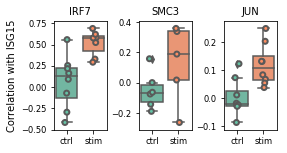

In [199]:
gene = 'ISG15'
tfs = ['IRF7', 'SMC3', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with ISG15')
    else:
        plt.ylabel(None)
plt.savefig(fig_path + 'cd4_ISG15_dc.pdf', bbox_inches='tight')


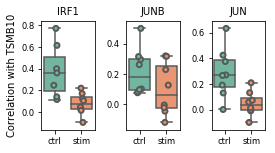

In [200]:
gene = 'TMSB10'
tfs = ['IRF1', 'JUNB', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with TSMB10')
    else:
        plt.ylabel(None)
        
plt.savefig(fig_path + 'cd4_TSMB10_dc.pdf', bbox_inches='tight')


### Network figure

In [62]:
def get_heatmap_df(adata_ct, normalize=False):
    
    mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
    mat[mat == 0] = np.nan
    mat[mat < -1] = np.nan
    mat[mat > 1] = np.nan

    # mat = np.clip(mat, a_min=-0.6, a_max=0.6)

    if normalize:
        means = np.nanmean(mat, axis=0)
        scales = np.nanstd(mat, axis=0)
        mat = (mat - means)/scales
        mat = np.clip(mat, a_min=-1.5, a_max=1.5)
    mat[~np.isfinite(mat)] = 0
    heatmap_df = pd.DataFrame(
        mat, 
        index=adata_ct.uns['scmemo']['2d_moments']['gene_2'], 
        columns=adata_ct.uns['scmemo']['2d_moments']['gene_1']
    ).dropna(0, 'any').fillna(0.0)

    return heatmap_df

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


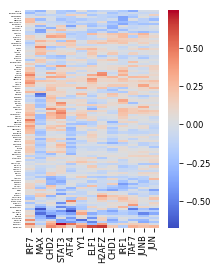

In [68]:
heatmap_df_Th = get_heatmap_df(adata_Th, normalize=False)[tf_overlap]#.loc[target_overlap]

cg = sns.clustermap(
    heatmap_df_Th.loc[sig_target],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
#     metric='cosine'
    );
cg.ax_row_dendrogram.set_visible(False)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
selected_rows = list(range(35, 65)) + list(range(100, 132))
plt.close()


plt.figure(figsize=(3, 4))
to_drop = ['CBX3','NELFE', 'NR3C1', 'NCOR1', 'GTF2B', 'CEBPB']
temp = heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order]
temp = temp[[col for col in temp.columns if col not in to_drop]]
temp.columns = temp.columns.map(lambda x: x.split('_')[0])
sns.heatmap(temp, cmap='coolwarm')
plt.yticks(np.arange(temp.shape[0])+0.5, temp.index, fontsize=2.4);
plt.tick_params(axis='y', length = 0)
# plt.savefig(fig_path + 'cd4_tf_stim_corrs.pdf', bbox_inches='tight')


In [110]:
final_tf_list = temp.columns.tolist()

In [70]:
gene_set_1 = heatmap_df_Th.loc[sig_target].iloc[row_order[30:90], col_order].index.tolist()
gene_set_2 = heatmap_df_Th.loc[sig_target].iloc[row_order[90:], col_order].index.tolist()
# final_tfs = [col for col in gene_set_1.columns if col not in to_drop]
# gene_set_1.columns = gene_set_1.columns.map(lambda x: x.split('_')[0])
# gene_set_2.columns = gene_set_2.columns.map(lambda x: x.split('_')[0])


In [116]:
ctrl_corr_df = pd.DataFrame(
    data=adata_Th.uns['scmemo']['2d_moments']['sg^ctrl']['corr'].T,
    index=adata_Th.uns['scmemo']['2d_moments']['gene_2'],
    columns=adata_Th.uns['scmemo']['2d_moments']['gene_1'])
ctrl_corr_df = ctrl_corr_df.loc[gene_set_2, final_tf_list].dropna().clip(-0.7, 0.7)

stim_corr_df = pd.DataFrame(
    data=adata_Th.uns['scmemo']['2d_moments']['sg^stim']['corr'].T,
    index=adata_Th.uns['scmemo']['2d_moments']['gene_2'],
    columns=adata_Th.uns['scmemo']['2d_moments']['gene_1'])
stim_corr_df = stim_corr_df.loc[gene_set_2, final_tf_list].dropna().clip(-0.7, 0.7)

In [105]:
import networkx as nx

In [140]:
G = nx.Graph()
G.add_nodes_from(gene_set_1)
G.add_nodes_from(gene_set_2)
pos = nx.circular_layout(G, scale=3).values()
pos = dict(zip(gene_set_1 + gene_set_2, circle_values))

G.add_nodes_from(final_tf_list)
for tf, gene in itertools.product(final_tf_list, gene_set_2):
    G.add_edge(tf, gene, weight=ctrl_corr_df.loc[gene, tf])

In [129]:
big_circle = nx.circular_layout(G, scale=3)
small_circle = nx.circular_layout(G, scale=1)

In [130]:
pos = {g:(small_circle[g] if g in final_tf_list else big_circle[g]) for g in G.nodes()}

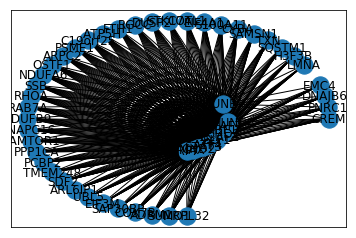

In [132]:
nx.draw_networkx(G, pos=pos, scale=3)

In [125]:
circle

{'CREM': array([1.00000000e+00, 1.06704544e-09]),
 'PNRC1': array([0.99323833, 0.11609291]),
 'DNAJB6': array([0.97304487, 0.23061587]),
 'EMC4': array([0.93969262, 0.34202012]),
 'JUNB': array([0.89363265, 0.44879919]),
 'LMNA': array([0.83548778, 0.54950899]),
 'H3F3B': array([0.76604444, 0.64278757]),
 'SQSTM1': array([0.68624163, 0.72737366]),
 'TXN': array([0.59715861, 0.80212319]),
 'SAMSN1': array([0.49999997, 0.86602544]),
 'CYBA': array([0.39607972, 0.91821611]),
 'S100A11': array([0.28680328, 0.95798951]),
 'EIF4A1': array([0.17364823, 0.98480773]),
 'COTL1': array([0.05814486, 0.99830818]),
 'STK17A': array([-0.05814482,  0.99830818]),
 'DUSP2': array([-0.17364819,  0.98480773]),
 'RGCC': array([-0.28680324,  0.95798951]),
 'FTH1': array([-0.3960798 ,  0.91821611]),
 'ATP5H': array([-0.50000005,  0.86602538]),
 'C19orf25': array([-0.59715854,  0.80212325]),
 'PSME1': array([-0.68624168,  0.7273736 ]),
 'ARPC2': array([-0.76604443,  0.64278763]),
 'OSTF1': array([-0.83548771,

In [112]:
ctrl_corr_df

,IKZF1,CEBPZ,CHD2,MYC,H2AFZ,BCLAF1,IRF7,REST,NR3C1,CHD1,...,MAX,ELF1,IRF1,IRF3,YY1,STAT3,ATF6B,NELFE,TAF7,JUN
CREM,-0.152276,0.136060,0.238330,-0.177284,0.034384,0.233821,0.078571,0.087702,0.367001,0.348975,...,0.073333,0.187276,0.157098,-0.101452,0.066908,0.129864,-0.016818,0.062617,0.077370,0.216374
PNRC1,0.025497,0.141917,0.151854,0.069021,0.225219,0.474010,0.004652,0.039734,-0.058603,0.342810,...,0.358954,0.164625,0.320124,-0.083290,0.197044,0.251459,0.092899,0.055670,0.225374,0.217379
DNAJB6,-0.050611,0.022534,0.279325,-0.008387,0.424250,0.457013,-0.051642,0.167093,-0.002129,0.588294,...,0.238388,0.491015,0.605100,-0.091430,0.380904,0.307049,0.013788,0.022720,0.425769,0.415545
EMC4,-0.069023,0.040647,-0.022778,-0.157607,0.067856,0.249029,-0.022398,-0.025882,0.031031,0.051170,...,0.266796,0.170727,0.066310,-0.129147,0.081636,-0.097849,-0.030727,0.109644,-0.021718,0.030696
JUNB,-0.055199,0.069745,0.332851,0.071567,0.234839,0.272850,0.013192,-0.002033,0.041977,0.356883,...,0.167785,0.347904,0.393067,-0.076566,0.281368,0.292821,-0.083238,-0.700000,0.369710,0.473167
LMNA,-0.071398,0.067318,0.271668,-0.046692,0.060535,0.184413,0.069292,0.001660,0.137310,0.207521,...,0.071915,0.146473,0.115177,-0.108992,0.137476,0.114081,-0.040780,0.084423,0.004055,0.107402
H3F3B,-0.116370,0.083129,0.305074,-0.035397,0.252868,0.391133,0.148658,0.081529,0.158247,0.387207,...,0.133958,0.300951,0.412946,-0.097300,0.282115,0.278275,0.006773,-0.051918,0.222173,0.338674
SQSTM1,0.036094,0.023837,0.182693,-0.046600,-0.039389,0.006747,0.051288,-0.061030,0.036633,0.022732,...,0.001731,0.039701,-0.004428,0.125869,-0.004995,0.018242,-0.077422,0.204256,-0.094929,0.035916
TXN,-0.082737,0.107580,0.030357,-0.150208,0.010744,0.176995,0.251771,0.062645,0.241858,-0.021654,...,0.102569,0.141520,-0.011638,-0.036527,-0.010849,-0.039331,-0.012627,0.397101,-0.163160,-0.074457
SAMSN1,-0.075056,0.126257,0.014383,-0.128838,0.059047,0.161178,-0.048992,0.074304,0.287813,0.120678,...,0.005513,0.084492,0.054566,0.105883,-0.023932,-0.030843,-0.009377,0.017332,-0.026401,0.084145


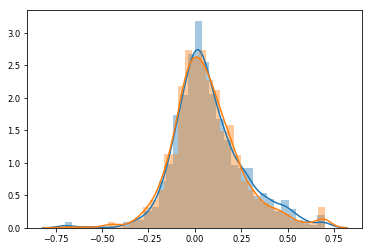

In [103]:
sns.distplot(ctrl_corr_df.values.ravel())
sns.distplot(stim_corr_df.values.ravel())

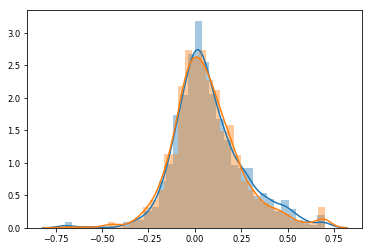

In [104]:
sns.distplot(ctrl_corr_df.values.ravel())
sns.distplot(stim_corr_df.values.ravel())

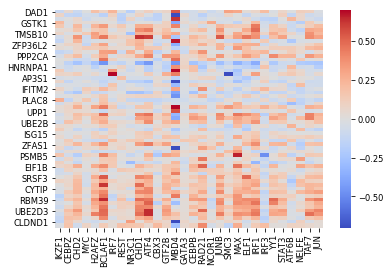

In [98]:
sns.heatmap(ctrl_corr_df, cmap='coolwarm', center=0)

In [72]:
gene_set_2

['CREM',
 'PNRC1',
 'DNAJB6',
 'EMC4',
 'JUNB',
 'LMNA',
 'H3F3B',
 'SQSTM1',
 'TXN',
 'SAMSN1',
 'CYBA',
 'S100A11',
 'EIF4A1',
 'COTL1',
 'STK17A',
 'DUSP2',
 'RGCC',
 'FTH1',
 'ATP5H',
 'C19orf25',
 'PSME1',
 'ARPC2',
 'OSTF1',
 'NDUFA6',
 'SSB',
 'RHOA',
 'RAB7A',
 'NDUFB9',
 'ANAPC16',
 'LAMTOR1',
 'PPP1CA',
 'PCBP2',
 'TMEM248',
 'SDF2',
 'ARL6IP1',
 'UBL5',
 'EIF3M',
 'SAP30BP',
 'COX7B',
 'ADRM1',
 'SUMO1',
 'MRPL32']

### Calibration

In [37]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

In [38]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(schypo)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
schypo.compute_2d_moments(
    adata_ct, 
    np.random.choice(target_genes, 50, replace=False), 
    np.random.choice(target_genes, 50, replace=False))

Size of data (5341, 3764)
TF list length 43


In [62]:
schypo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=2500)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   10.8s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   23.6s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   38.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   55.5s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 2497 out of 2497 | elapsed:  2.8min finished


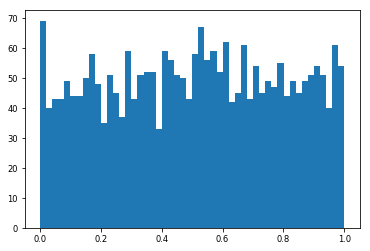

In [67]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=50);

In [68]:
df = schypo.get_2d_ht_result(adata_ct)

In [69]:
df.query('corr_fdr < 0.1')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
31,PURB,SLC25A28,0.554546,2.948096e-07,7.364345e-05
35,PURB,NUPL1,0.964153,4.633082e-12,2.893360e-09
340,RPSAP58,AP3M1,0.496133,2.443153e-10,8.718566e-08
630,NFAT5,RELT,1.398062,6.476545e-04,5.578762e-02
662,EPC2,ADI1,0.296509,1.989098e-05,2.258531e-03
666,EPC2,IL18,0.182543,1.072148e-05,1.339113e-03
673,EPC2,UBE4A,0.160806,1.070138e-05,1.339113e-03
709,CSNK2A1,SLC25A51,0.712058,2.869033e-05,2.986185e-03
736,CSNK2A1,RREB1,0.484825,7.401955e-11,3.081681e-08
1016,MED27,IL18,0.199681,2.285487e-07,6.343496e-05


In [66]:
print(df.query('corr_fdr < 0.1').shape)
df.query('corr_fdr < 0.1')

(29, 5)


,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
31,PURB,SLC25A28,0.554546,2.948096e-07,7.364345e-05
35,PURB,NUPL1,0.964153,4.633082e-12,2.893360e-09
340,RPSAP58,AP3M1,0.496133,2.443153e-10,8.718566e-08
630,NFAT5,RELT,1.398062,6.476545e-04,5.578762e-02
662,EPC2,ADI1,0.296509,1.989098e-05,2.258531e-03
666,EPC2,IL18,0.182543,1.072148e-05,1.339113e-03
673,EPC2,UBE4A,0.160806,1.070138e-05,1.339113e-03
709,CSNK2A1,SLC25A51,0.712058,2.869033e-05,2.986185e-03
736,CSNK2A1,RREB1,0.484825,7.401955e-11,3.081681e-08
1016,MED27,IL18,0.199681,2.285487e-07,6.343496e-05


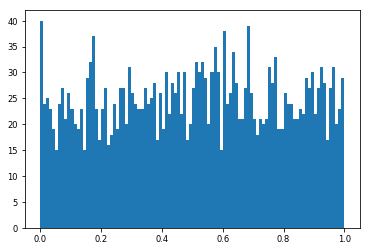

In [60]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=100);

In [61]:
print(df.query('corr_fdr < 0.1').shape)
df.query('corr_fdr < 0.1')

(22, 5)


,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
31,PURB,SLC25A28,0.554546,4.735113e-07,1.182831e-04
35,PURB,NUPL1,0.964153,5.847578e-09,3.651813e-06
340,RPSAP58,AP3M1,0.496133,1.774115e-05,2.485923e-03
662,EPC2,ADI1,0.296509,2.855611e-07,7.925908e-05
666,EPC2,IL18,0.182543,2.260403e-06,4.343451e-04
709,CSNK2A1,SLC25A51,0.712058,1.229271e-04,1.395781e-02
736,CSNK2A1,RREB1,0.484825,6.472562e-07,1.469860e-04
1016,MED27,IL18,0.199681,2.596218e-07,7.925908e-05
1023,MED27,UBE4A,0.821872,1.010950e-07,4.208922e-05
1027,MED27,POU2F1,0.917629,1.963684e-07,7.007548e-05
